# Cleaning the Open PV Data Set

Ultimately, it would be great to be able to merge in the zipcode NREL Solar to this, to use this to predict cost per watt and reported annual energy produced.  There's a ton of blank values, and this is self reported data, so it's probably going to require a LOT of cleaning.

In [1]:
import pandas as pd
import numpy as np


In [2]:
# loading in the open_pv_all data set

df = pd.read_csv("./openpv_all.csv")

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,5,8,12,13,14,15,16,20,23,25,26,27,28,32,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# There are a bunch of columns that are totally null, just going to get rid of all of those.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 81 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           797958 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean 

In [4]:
# Getting rid of columns where there's no data

# first getting a list all the column names where there's no data.

non_null_cols = [col for col in df.columns if df[col].notnull().sum() != 0]

In [5]:
# limiting the dataframe to just non-null columns

df = df[non_null_cols]

In [6]:
# it worked!

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           797958 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean 

## Incentive Program Names


These are probably pretty important to determining cost, so let's see if we can find some trend to impute it.

In [7]:
# There are a bunch of these incentive programs, which almost definitely have an influence on people's
# eventual cost of solar.

df['incentive_prog_names'].value_counts()

California Public Utilities Commission (Non-CSI Net Metered Systems)          260940
California Public Utilities Commission (California Solar Initiative)          148988
New York State Energy Research and Development Authority                       44012
Arizona Public Service                                                         40647
Massachusetts Clean Energy Center                                              36810
New Jersey Board of Public Utilities (SREC Program)                            34168
California Energy Commission (Emerging Renewables Program)                     27952
Massachusetts Department of Energy Resources                                   24828
Los Angeles Department of Water & Power                                        19757
California Energy Commission (New Solar Homes Partnership)                     17286
Connecticut Clean Energy Finance and Investment Authority                      15746
Salt River Project                                               

In [8]:
# let's look at average cost_per_watt for these different commisions:

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


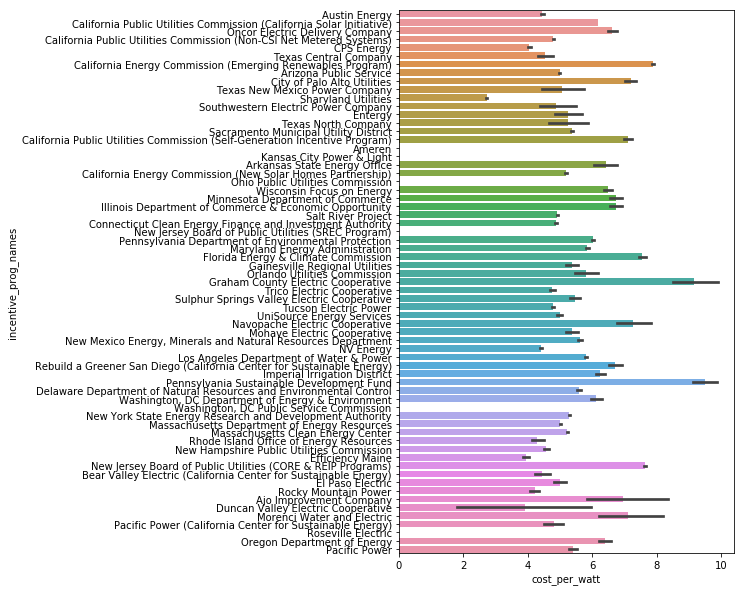

In [9]:
# There's definitely some variance around this, and it looks like within each of these the variance or price
# is pretty tight.

fig = plt.figure(figsize=(6,10))

sns.barplot(x=df["cost_per_watt"], y=df["incentive_prog_names"], orient = 'h')

In [10]:
# Either values where the incentive is plank means they didn't have an incentive program, or that 
# it isn't listed.  If it's the latter, maybe we can impute it.

null_incentive_state = df.loc[df['incentive_prog_names'].isnull(), :].groupby("state").size()

In [11]:
# looking at proportion by state with no incentive program compared to with incentive program may provide some clues

zip(null_incentive_state.sort_values(ascending=False).index, sorted(null_incentive_state/sum(null_incentive_state), reverse=True))

In [12]:
notnull_incentive_state = df.loc[df['incentive_prog_names'].notnull(), :].groupby("state").size()

zip(notnull_incentive_state.sort_values(ascending=False).index, sorted(notnull_incentive_state/sum(notnull_incentive_state), reverse=True))

In [13]:
# looks like some states don't even show up, probably safe to assume that those states just don't have 
# incentive programs.

# given that, it seems like it may be difficult to distingush between cases where there was no incentive program
# available and where it was unreported.

df['incentive_prog_names'].fillna("no_incentive_program", inplace=True)

## Utility_Clean

I have a hunch that this is going to be heavily linked to states and/or counties, we can probably impute this by grabbing the mode value from each state or county.  Let's explore.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           1020715 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean

In [15]:
# We can already see that there's quite a bit of deviation within states, for instance a lof of CA is on 
# Los Angeles Department of Water & Power, and a lot is on Pacific Gas & Electric Co, maybe county will help.

df.groupby(['state', 'utility_clean']).size()

state  utility_clean                              
AR     Carroll Electric Coop Corp                         1
       Carroll Electric Coop Corp - (AR)                  1
       Entergy Arkansas Inc                              61
       Oklahoma Gas & Electric Co                         3
       Southwestern Electric Power Co                    32
AZ     Ajo Improvement Company                            3
       Arizona Public Service                         40647
       Duncan Valley Electric Cooperative                 5
       Graham County Electric Cooperative               129
       Mohave Electric Cooperative                      449
       Morenci Water and Electric                         3
       Navopache Electric Cooperative                   140
       Salt River Project                             15275
       Sulphur Springs Valley Electric Cooperative     1266
       Trico Electric Cooperative                      1357
       Tucson Electric Power                     

In [16]:
# this looks quite a bit better, looks like in most counties there's only one or maybe 2 utilities that
# people are on.

county_utilities = pd.DataFrame(df.groupby(['state', 'county', 'utility_clean']).size()).reset_index()
county_utilities

,state,county,utility_clean,0
0,AR,Benton,Southwestern Electric Power Co,6
1,AR,Boone,Entergy Arkansas Inc,3
2,AR,Carroll,Entergy Arkansas Inc,4
3,AR,Chicot,Entergy Arkansas Inc,1
4,AR,Crawford,Oklahoma Gas & Electric Co,2
5,AR,Faulkner,Entergy Arkansas Inc,3
6,AR,Franklin,Oklahoma Gas & Electric Co,1
7,AR,Garland,Entergy Arkansas Inc,4
8,AR,Grant,Entergy Arkansas Inc,2
9,AR,Hempstead,Entergy Arkansas Inc,1


In [17]:
# Looking at california, looks like this is pretty robust, I'm also noticing that there's a ton of double labled stuff
# let's also change 'Pacific Gas & Electric Co' to "Pacific Gas & Electric Company"

county_utilities[county_utilities['state'] == "CA"]

,state,county,utility_clean,0
71,CA,Alameda,Pacific Gas & Electric Co,191
72,CA,Alameda,Pacific Gas & Electric Company,16285
73,CA,Alameda,Port of Oakland,1
74,CA,Alameda,Southern California Edison,5
75,CA,Amador,Pacific Gas & Electric Co,1
76,CA,Amador,Pacific Gas & Electric Company,663
77,CA,Butte,Pacific Gas & Electric Co,76
78,CA,Butte,Pacific Gas & Electric Company,5383
79,CA,Butte,Southern California Edison,1
80,CA,Calaveras,Pacific Gas & Electric Company,1047


In [18]:
# changing some misnamed PG&E values

df.loc[df['utility_clean'] == "Pacific Gas & Electric Co", 'utility_clean'] = "Pacific Gas & Electric Company"

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           1020715 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean

In [5]:
# I'm just going to go ahead and impute the utility based on the mode for teh state

In [20]:
import sqlite3

conn = sqlite3.Connection("./capstone.sqlite")
conn.text_factory = str

df.to_sql('open_pv_clean', con=conn, if_exists='replace')

In [21]:
# cleaning up some fucked up shit with state entries.

df.loc[df['state'] == 'PA ', 'state'] = 'PA'
df.loc[df['state'] == 'MD ', 'state'] = 'MD'
df.loc[df['state'] == 'OH ', 'state'] = "OH"
states = list(df.state.unique())

In [22]:
# Looks like there are a few states where there's no listing.  let's just fill the states where there are some
# utility listings, and fill the other ones with "no utility listed"

for state in states:
    print(state, "non_nulls: ", df.loc[df['state'] == state, 'utility_clean'].notnull().sum())
    print(state, "nulls: ", df.loc[df['state'] == state, 'utility_clean'].isnull().sum())
    print("\n")

TX non_nulls:  9585
TX nulls:  4768


IN non_nulls:  0
IN nulls:  913


CA non_nulls:  492026
CA nulls:  134794


OK non_nulls:  0
OK nulls:  11


OH non_nulls:  43
OH nulls:  2250


IL non_nulls:  1101
IL nulls:  385


MI non_nulls:  0
MI nulls:  264


VA non_nulls:  0
VA nulls:  71


WI non_nulls:  1926
WI nulls:  1395


CO non_nulls:  0
CO nulls:  2606


MD non_nulls:  6266
MD nulls:  5177


FL non_nulls:  1821
FL nulls:  1163


NY non_nulls:  44012
NY nulls:  7007


MA non_nulls:  61635
MA nulls:  9786


PA non_nulls:  7233
PA nulls:  4238


AZ non_nulls:  72022
AZ nulls:  17339


UT non_nulls:  430
UT nulls:  387


KY non_nulls:  0
KY nulls:  33


DE non_nulls:  3022
DE nulls:  2102


WA non_nulls:  0
WA nulls:  209


IA non_nulls:  0
IA nulls:  206


MS non_nulls:  0
MS nulls:  71


HI non_nulls:  0
HI nulls:  2324


KS non_nulls:  0
KS nulls:  28


GA non_nulls:  0
GA nulls:  53


ME non_nulls:  519
ME nulls:  184


NH non_nulls:  2893
NH nulls:  608


CT non_nulls:  15727
CT nu

In [31]:
states = list(df.state.unique())

for state in states:
    non_nulls = df.loc[df['state'] == state, 'utility_clean'].notnull().sum()
    if non_nulls == 0:
        df.loc[df['state'] == state, 'utility_clean'] = "no utility listed"
    else:
        mode_utility = df.loc[df['state'] == state, 'utility_clean'].value_counts().index[0]
        mask = (df['state'] == state) & (df['utility_clean'].isnull())
        df.loc[mask, 'utility_clean'] = mode_utility
        
print(df['utility_clean'].isnull().sum())

0


In [140]:
df.loc[df['state'] == 'CA', 'utility_clean'].isnull().sum()

0

In [141]:
df.groupby(['state', 'utility_clean']).size()

state  utility_clean                              
AK     no utility listed                                 22
AL     no utility listed                                 32
AR     Carroll Electric Coop Corp                         1
       Carroll Electric Coop Corp - (AR)                  1
       Entergy Arkansas Inc                             202
       Oklahoma Gas & Electric Co                         3
       Southwestern Electric Power Co                    32
AZ     Ajo Improvement Company                            3
       Arizona Public Service                         57985
       Duncan Valley Electric Cooperative                 5
       Graham County Electric Cooperative               129
       Mohave Electric Cooperative                      449
       Morenci Water and Electric                         3
       Navopache Electric Cooperative                   140
       Salt River Project                             15275
       Sulphur Springs Valley Electric Cooperativ

In [80]:
# saving this to the db
df.to_sql("open_pv_clean", con=conn, if_exists="replace")

# Install Type

In [18]:
df = pd.read_sql("SELECT * FROM open_pv_clean", con=conn)

In [81]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020303 entries, 0 to 1020302
Data columns (total 39 columns):
state                          1020303 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020303 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      224036 non-null object
zipcode                        1020298 non-null float64
install_type                   977722 non-null object
installer                      702324 non-null object
cost_per_watt                  762737 non-null float64
cost                           998765 non-null object
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           798736 non-null object
utility_clean                  1020303 non-null object
tech_1                         580919 non-null object
model1_clean

In [82]:
# looks like there's a lot of improperly named stuff here.  if we just make them all lower case that will help.

# we can also probably safely impute the empty values with residential.  Maybe there's some connection between
# size and type though, let's look at a box plot for that.

df.install_type.value_counts()

residential                    728661
Residential                    179166
commercial                      24470
Unknown                         15770
Commercial                      11868
unknown                          4034
government                       3721
nonprofit                        3003
Government                       2024
educational                      1703
Nonprofit                        1216
Educational                       709
Customer                          371
education                         290
Agricultural                      267
Utility                           138
agricultural                      124
utility                            92
Institutional                      29
Commercial - Other                 16
Gov't/NP                           11
Public                             11
agriculture                         5
Residential/SF                      5
public                              5
Nonresidential                      3
Commercial -

In [150]:
# setting it all to lower case

df['install_type'] = [install.lower() for install in df['install_type'].astype(str)]

In [151]:
# consolidating commercial

df['install_type'] = ['commercial' if "commercial" in install else install for install in df['install_type']]

In [152]:
df['install_type'] = ['educational' if "educat" in install else
                      'commercial' if 'commer' in install else
                      'public' if "gov't" in install else
                      'residential' if '/sf' in install else
                      'agricultural' if 'agricu' in install else
                      'public' if install == 'municipal' 
                      else install for install in df['install_type']]

In [96]:
df['install_type'].value_counts()

residential       907832
nan                42581
commercial         36359
unknown            19804
government          5745
nonprofit           4219
educational         2702
agricultural         396
customer             371
utility              230
institutional         29
public                28
nonresidential         3
small business         2
not stated             2
Name: install_type, dtype: int64

In [153]:
# let's make some of the rando one's nan and get rid of small-business

nan_labels = ['nonresidential', 'not stated', 'unknown', 'customer']

df['install_type'] = ['nan' if install in nan_labels else
                     'commercial' if 'small business' in install else
                     install for install in df['install_type']]

In [98]:
# residential seriously dominates, but maybe there's some big trend we can use to imput the nan

df['install_type'].value_counts()

residential      907832
nan               62761
commercial        36361
government         5745
nonprofit          4219
educational        2702
agricultural        396
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

In [154]:
df['install_type'] = [np.nan if install == 'nan' else install for install in df['install_type']]

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

(0, 20000)

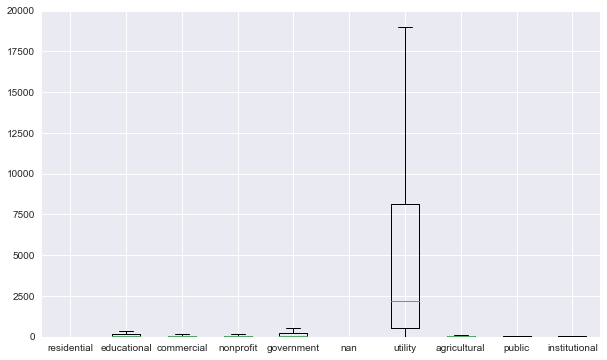

In [111]:
fig = plt.figure(figsize=(10,6))

# kind of hard to get anything out of this, also wtf nan and residential are just not even showing up.

data = [df.loc[df['install_type'] == install, 'size_kw'] for install in df['install_type'].unique()]
plt.boxplot(data, labels = df['install_type'].unique())
plt.ylim(0,20000)

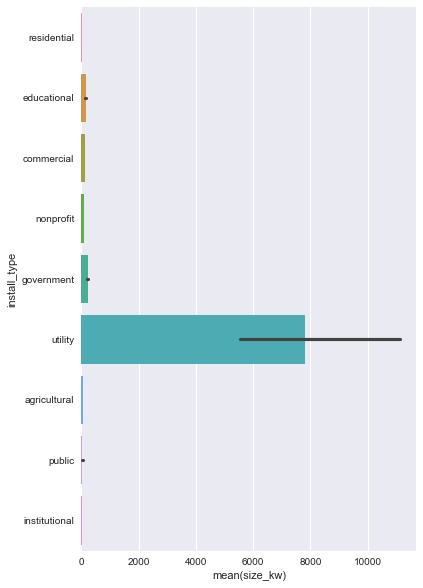

In [113]:
fig = plt.figure(figsize=(6,10))
sns.barplot(y=df['install_type'], x=df['size_kw'], orient='h')

In [155]:
# okay looks like anything larger than the max government one we can for sure say is utility, that's interesting
# we have to ge rid of utility to see anything else.

utility_cutoff = df.loc[df['install_type'] == 'utility', 'size_kw'].max()

In [117]:
utility_cutoff

333000.0

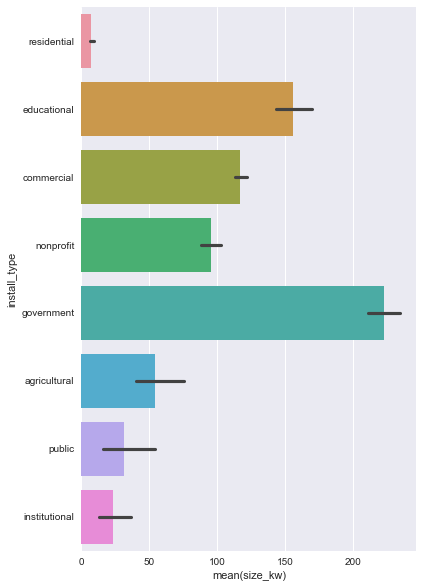

In [120]:
fig = plt.figure(figsize=(6,10))
sns.barplot(y=df.loc[df['install_type'] != 'utility', 'install_type'],
            x=df.loc[df['install_type'] != 'utility','size_kw'], orient='h')

In [121]:
df.install_type.value_counts()

residential      907832
commercial        36361
government         5745
nonprofit          4219
educational        2702
agricultural        396
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

In [156]:
# I'll just make cutoffs for utility because it's such a standout, then residential, commercial, and government.

# utility if > utility cuttoff
# governement if <= utility cutoff and > education max
# commercial if <= education max and > institutional max
# residuential if <= instutional max

utility_cutoff = df.loc[df['install_type'] == 'utility', 'size_kw'].max()
education_max = df.loc[df['install_type'] == 'educational', 'size_kw'].max()
instit_max = df.loc[df['install_type'] == 'institutional', 'size_kw'].max()


def install_filler(row):
    # this function will go through every row and fill in null values for install_type with a value based on the 
    # size of the installation
    
    # check if row is null.
    if row['install_type'] == np.nan:
        
        # check if there's a size we can go off of.
        if row['size_kw'] == np.nan:
            
            # compare size
            if row['size_kw'] > utility_cutoff:
                row['install_type'] = 'utility'
            elif row['size_kw'] <= utility_cutoff and row['size_kw'] > education_max:
                row['install_type'] = 'government'
            elif row['size_kw'] <= education_max and row['size_kw'] > instit_max:
                row['install_type'] = 'commercial'
            else:
                row['install_type'] = 'residential'
                
    return row 

In [157]:
df = df.apply(install_filler, axis=1)

In [129]:
# forgot to fill ones that don't have a size with residential.

df.install_type.isnull().sum()

62761

In [158]:
df.install_type.fillna(value='residential', inplace=True)

In [159]:
df.install_type.isnull().sum()

0

In [160]:
# we did it.

df.install_type.value_counts()

residential      970593
commercial        36361
government         5745
nonprofit          4219
educational        2702
agricultural        396
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

In [34]:
del(df['index'])

In [35]:
# saving to the database.

df.to_sql('open_pv_clean_backup', con=conn, if_exists="replace")

In [36]:
df.to_sql('open_pv_clean', con=conn, if_exists="replace")

# Appraised

In [161]:
# looks like it's just one value, seems safe to assume that it's just a binary thing, so we can just leave it blank

df.appraised.value_counts()

True    224036
Name: appraised, dtype: int64

In [165]:
# I'm going to change this to a 1 / 0 ohe situation.

df.appraised.fillna(0, inplace=True)

In [166]:
mask = df.appraised == True
df.loc[mask, 'appraised'] = 1

In [168]:
df.appraised = pd.to_numeric(df.appraised)

# Zipcode and address information

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020303 entries, 0 to 1020302
Data columns (total 39 columns):
state                          1020303 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020303 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      224036 non-null object
zipcode                        1020298 non-null float64
install_type                   1020303 non-null object
installer                      702324 non-null object
cost_per_watt                  762737 non-null float64
cost                           998765 non-null object
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           798736 non-null object
utility_clean                  1020303 non-null object
tech_1                         580919 non-null object
model1_clea

In [136]:
# looks like these just suck i'm dropping them.

df.loc[df['zipcode'].isnull(), :]

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,reported_annual_energy_prod,year,pbi_length,utility,bipv_3,bipv_2,bipv_1,new_constr,tracking,3rdparty
491,IN,NaN,no_incentive_program,NaN,NaN,NaN,NaN,residential,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283092,OH,NaN,no_incentive_program,NaN,NaN,NaN,NaN,residential,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283109,PA,NaN,no_incentive_program,NaN,NaN,NaN,NaN,residential,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283280,OH,NaN,no_incentive_program,NaN,NaN,NaN,NaN,residential,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283299,PA,NaN,no_incentive_program,NaN,NaN,NaN,NaN,residential,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
df = df.loc[df['zipcode'].notnull(), :]

In [ ]:
df.to_sql('open_pv_clean', con=conn, if_exists="replace")

# Installer

In [139]:
# installer is probably going to be regionally dependent, so maybe we can just do something similar to utility?

df.installer.value_counts()

SolarCity                                              168125
Vivint                                                  41615
Sunpower                                                19925
Verengo                                                 16396
Sungevity                                               14939
Rec Solar                                               14291
PetersenDean                                            11235
RGS/Real Goods                                          10951
Sunrun                                                   9968
Grid Alternatives                                        8119
Trinity Heating & Air                                    7966
Roof Diagnostics Solar & Electric                        6012
Self                                                     5345
American Solar Direct                                    4917
Direct Energy Solar                                      4761
American Solar Electric                                  4453
Future E

In [ ]:
# for state in states:
#     non_nulls = df.loc[df['state'] == state, 'installer'].notnull().sum()
#     if non_nulls == 0:
#         df.loc[df['state'] == state, 'utility_clean'] = "no utility listed"
#     else:
#         mode_utility = df.loc[df['state'] == state, 'utility_clean'].value_counts().index[0]
#         df.loc[df['state'] == state, 'utility_clean'] = mode_utility
        
# print df['utility_clean'].isnull().sum()

In [154]:
# doesn't look like there's necesarily a clear connection between county and installer.

mask = df['county'] == "Alameda"
county_installers = pd.DataFrame(df.loc[mask, :].groupby(['installer']).size()).sort_values(0, ascending=False)
county_installers

,0
installer,
SolarCity,4145
Sungevity,993
PetersenDean,799
Solar Company,496
Sun Light & Power,436
Vivint,381
Rec Solar,361
Grid Alternatives,294
RGS/Real Goods,289


In [156]:
sc_percent = 4145./sum(county_installers.values)[0]

In [157]:
# solar city is 4 times bigger than the next biggest installer in alameda county and yet only as 26% of the installations.

sc_percent

0.2679206256867688

In [159]:
# also, there's 10k installers... seems insane that I would actually use this as a feature.

len(df.installer.value_counts())

10954

In [170]:
state_installers = []

for state in states:
    non_nulls = df.loc[df['state'] == state, 'installer'].notnull().sum()
    mode_installer = None
    if non_nulls == 0:
        print state, "no installers", 0
        mode_installer = "no installers"
    else:
        percent_biggest = float(df.loc[df['state'] == state, 'installer'].value_counts().values[0])/sum(df.loc[df['state'] == state, 'installer'].value_counts().values)
        print state, df.loc[df['state'] == state, 'installer'].value_counts().index[0], percent_biggest
        mode_installer = df.loc[df['state'] == state, 'installer'].value_counts().index[0]
    state_installers.append({
        "state": state,
        "mode_installer": mode_installer
    }
    )

state_mode_installers = pd.DataFrame(state_installers)
state_mode_installers

TX Advanced Solar & Electric 0.216222819448
CA SolarCity 0.224797902416
VA Paradise Energy Solutions 1.0
WI Arch Electric - 297 0.0965189873418
CO no installers 0
MD SolarCity 0.170542635659
OH Paradise Energy Solutions 1.0
FL Solar Impact 0.115446285409
NY Paradise Energy Solutions 0.897058823529
MA SolarCity 0.286284866566
DE Sungevity 0.170532060027
WA no installers 0
IA Ideal Energy 0.913793103448
MS no installers 0
IN Whole Sun Designs Inc 0.268421052632
HI no installers 0
KS SoCore Energy 1.0
GA no installers 0
ME ReVision Energy 0.565217391304
NH Revision Energy 0.582706766917
CT SolarCity 0.318886582835
IL Solar Service 0.116161616162
VT Integrated Solar and REC Solar 1.0
NM Consolidated Solar Technologies 0.2031225605
AL no installers 0
MO Microgrid Solar Energy 0.158328752062
KY Morton Solar, LLC 0.777777777778
NJ Trinity Heating & Air 0.189569398491
AK no installers 0
MN All Energy Solar 0.212410501193
MI no installers 0
PA Direct Energy Solar 0.0714092140921
MT no installer

,mode_installer,state
0,Advanced Solar & Electric,TX
1,SolarCity,CA
2,Paradise Energy Solutions,VA
3,Arch Electric - 297,WI
4,no installers,CO
5,SolarCity,MD
6,Paradise Energy Solutions,OH
7,Solar Impact,FL
8,Paradise Energy Solutions,NY
9,SolarCity,MA


In [169]:
df['installer'].value_counts()

SolarCity                                              168125
Vivint                                                  41615
Sunpower                                                19925
Verengo                                                 16396
Sungevity                                               14939
Rec Solar                                               14291
PetersenDean                                            11235
RGS/Real Goods                                          10951
Sunrun                                                   9968
Grid Alternatives                                        8119
Trinity Heating & Air                                    7966
Roof Diagnostics Solar & Electric                        6012
Self                                                     5345
American Solar Direct                                    4917
Direct Energy Solar                                      4761
American Solar Electric                                  4453
Future E

In [171]:
df.columns

Index([u'state', u'date_installed', u'incentive_prog_names', u'type',
       u'size_kw', u'appraised', u'zipcode', u'install_type', u'installer',
       u'cost_per_watt', u'cost', u'lbnl_tts_version_year', u'lbnl_tts',
       u'city', u'utility_clean', u'tech_1', u'model1_clean', u'county',
       u'annual_PV_prod', u'annual_insolation', u'rebate', u'sales_tax_cost',
       u'tilt1', u'tracking_type', u'azimuth1', u'manuf2_clean',
       u'manuf3_clean', u'manuf1_clean', u'inv_man_clean',
       u'reported_annual_energy_prod', u'year', u'pbi_length', u'utility',
       u'bipv_3', u'bipv_2', u'bipv_1', u'new_constr', u'tracking',
       u'3rdparty'],
      dtype='object')

In [174]:
# interesting, looks like solarcity doesn't install many mono systems, maybe we can assign all the blanks
# to solarcity if they're not mono, and see who the biggest installer is for mono and assign the rest to that one.


# should go work on tech_1 next, this seems really important.
# crystalline should probably be changed to "poly" because 
df.loc[df['installer'] == 'SolarCity', 'tech_1'].value_counts()

Poly           121271
crystalline      2664
Mono             2658
CdTe              585
Mono + a-Si       297
CIGS                8
a-Si                3
Name: tech_1, dtype: int64

In [175]:
# sunpower appears to be far and away the biggest installer of these kind.

df.loc[df['tech_1'] == 'Mono', 'installer'].value_counts()

Sunpower                                                     14743
RGS/Real Goods                                                5156
Verengo                                                       4768
PetersenDean                                                  4339
Sungevity                                                     4107
Future Energy Corp                                            3349
Trinity Heating & Air                                         3135
Baker Electric                                                2855
Solar Company                                                 2760
SolarCity                                                     2658
A1 Solar Power                                                2356
Sullivan Solar Power                                          1790
Semper Solaris Construction                                   1724
Akeena                                                        1633
Self                                                          

In [177]:
df.loc[df['tech_1'] == 'Mono', 'installer'].notnull().sum()

190005

In [ ]:
df.loc[df['tech_1'] == 'Mono', 'installer'].value_counts()

In [180]:
df.loc[df['state'] == 'IL', 'installer'].value_counts()

Solar Service                                  46
Kapital Electric                               32
Solar Energy Of Illinois                       28
Earth Wind & Solar Energy                      22
Ailey Solar Electric                           22
Self                                           20
Renewable Energy Alternatives                  18
Tick Tock Energy                               16
Day & Night Solar                              14
Nadler Electrical Contracting                  13
Central Illinois Wind & Solar                  13
Straightup Solar                               12
Wcp Solar Services                             12
Sunair Systems                                 11
Windfree Wind & Solar                          10
Morton Solar                                    7
Tropic Construction                             7
Title Electric Company                          6
Renewable Alternative Energy                    5
Magitek Energy Solutions                        5


In [171]:
# want to go through each row, and fill in with the mode installer in the state if there is one.
# if there isn't, fill with Sunpower if the tech_1 is mono, else fill with solarcity.

state_installers = {}

states = list(df.state.unique())

for state in states:
    non_nulls = df.loc[df['state'] == state, 'installer'].notnull().sum()
    mode_installer = None
    if non_nulls == 0:
        mode_installer = "no installers"
    else:
        mode_installer = df.loc[df['state'] == state, 'installer'].value_counts().index[0]
    state_installers[state] = mode_installer



In [45]:
df.installer.isnull().sum()

317974

In [172]:
def fill_installer(row):
    # check to see if the installer category is null
    if row['installer'] is None:
        
        # checking if there are no installers listed in the state on this row.
        if state_installers[row['state']] == 'no installers':
            
            # if there are, check to see if tech is mono.
            if row['tech_1'] == "Mono":
                row['installer'] == "Sunpower"
            else:
                row['installer'] == "SolarCity"
        # if not no_installers, then we'll just set the null value to the mode installer from the state.
        else:    
            
            row['installer'] = state_installers[row['state']]
    
    return row

In [173]:
df = df.apply(fill_installer, axis=1)

In [71]:
df.to_sql("open_pv_clean_backup", con=conn, if_exists="replace")

In [72]:
df.to_sql("open_pv_clean", con=conn, if_exists="replace")

# Reimporting and doing some plotting!

This is a bit of a tangent from the cleaning, I'm doing some plotting with plotly and making maps of some stuff.

In [268]:
df = pd.read_sql("SELECT * FROM open_pv_clean", con=conn)

In [226]:
import plotly

plotly.tools.set_credentials_file(username='ebaker12', api_key='cFPfQyYq3wlwycDI2Ghc')

In [227]:
df.columns

Index([u'state', u'date_installed', u'incentive_prog_names', u'type',
       u'size_kw', u'appraised', u'zipcode', u'install_type', u'installer',
       u'cost_per_watt', u'cost', u'lbnl_tts_version_year', u'lbnl_tts',
       u'city', u'utility_clean', u'tech_1', u'model1_clean', u'county',
       u'annual_PV_prod', u'annual_insolation', u'rebate', u'sales_tax_cost',
       u'tilt1', u'tracking_type', u'azimuth1', u'manuf2_clean',
       u'manuf3_clean', u'manuf1_clean', u'inv_man_clean',
       u'reported_annual_energy_prod', u'year', u'pbi_length', u'utility',
       u'bipv_3', u'bipv_2', u'bipv_1', u'new_constr', u'tracking',
       u'3rdparty'],
      dtype='object')

In [288]:
df_state.to_sql("state_level_data", con=conn)

In [271]:
state_size_cost_energy = df.loc[df['install_type'] == 'residential', ['state', 'size_kw', 'cost_per_watt', 'cost', 'annual_insolation', 'reported_annual_energy_prod']].groupby("state").mean()   

state_size_cost_energy['installations'] = df.groupby('state').size().values

state_size_cost_energy.reset_index(level=0, inplace=True)


df_state = state_size_cost_energy.copy()

In [275]:
import plotly.plotly as py

# scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
#             [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


data = [ dict(
        type='choropleth',
        colorscale = "RdYlGn",
        autocolorscale = False,
        locations = df_state['state'],
        z = df_state['cost_per_watt'].astype(float),
        locationmode = 'USA-states',
        text = df_state['cost_per_watt'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Average Cost Per Watt"
        )
    ) ]

layout = dict(
        title = 'Average US Solar Cost Per Watt by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

url = py.plot( fig, filename='residential_avg_cost_per_watt' )

In [278]:
df.columns

Index([u'index', u'state', u'date_installed', u'incentive_prog_names', u'type',
       u'size_kw', u'appraised', u'zipcode', u'install_type', u'installer',
       u'cost_per_watt', u'cost', u'lbnl_tts_version_year', u'lbnl_tts',
       u'city', u'utility_clean', u'tech_1', u'model1_clean', u'county',
       u'annual_PV_prod', u'annual_insolation', u'rebate', u'sales_tax_cost',
       u'tilt1', u'tracking_type', u'azimuth1', u'manuf2_clean',
       u'manuf3_clean', u'manuf1_clean', u'inv_man_clean',
       u'reported_annual_energy_prod', u'year', u'pbi_length', u'utility',
       u'bipv_3', u'bipv_2', u'bipv_1', u'new_constr', u'tracking',
       u'3rdparty'],
      dtype='object')

In [280]:
df_ca = df.loc[((df['state'] == "CA") & (df['install_type'] == 'residential')), ['state', 'county', 'size_kw', 'cost_per_watt', 'cost', 'annual_insolation', 'reported_annual_energy_prod']].groupby("county").mean()





In [281]:
df_ca

,size_kw,cost_per_watt,annual_insolation,reported_annual_energy_prod
county,,,,
Alameda,5.527480,6.934129,5.243357,NaN
Alpine,3.896429,10.105714,NaN,NaN
Amador,6.215012,6.513088,5.349896,NaN
Butte,7.549414,6.117179,5.354022,NaN
Calaveras,6.930538,6.512830,5.357959,NaN
Colusa,10.614966,5.753081,5.315406,NaN
Contra Costa,5.468173,6.732658,5.272811,NaN
Del Norte,7.255985,5.327989,4.332815,7528.000000
El Dorado,5.634495,6.336167,5.363019,3565.000000


In [285]:
df_ca_nonan = df_ca[['size_kw', 'cost_per_watt', 'annual_insolation']].dropna()

In [287]:
# looks like surprisingly, price is NEGATIVELY correlated with annual insolation, and not totally insignificantly.

# mapping this stuff could be interesting.

df_ca_nonan.corr()

,size_kw,cost_per_watt,annual_insolation
size_kw,1.000000,-0.112979,0.002515
cost_per_watt,-0.112979,1.000000,-0.174306
annual_insolation,0.002515,-0.174306,1.000000


# Back to data cleaning

In [1]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.Connection("./capstone.sqlite")

df = pd.read_sql("SELECT * FROM open_pv_clean", con=conn)

In [295]:
# maybe we can impute cost? probably a function of technology and size.

# cost is an object, let's change that.

df['cost'].value_counts()

n/a          235867
30000.0        1572
25000.0        1443
20000.0        1276
22000.0        1236
24000.0        1186
27000.0        1047
21000.0        1035
33000.0        1025
18000.0         984
35000.0         897
40000.0         884
26000.0         874
28000.0         874
15000.0         869
28656.0         867
39402.0         848
19968.0         842
36000.0         837
24500.0         836
33432.0         834
35250.0         828
26268.0         807
26624.0         793
21492.0         773
45000.0         769
23000.0         763
27500.0         723
26400.0         720
23880.0         709
              ...  
278453.67         1
136312.0          1
12128.33          1
32577.6           1
39239.99          1
14907.63          1
12772.35          1
24396.2           1
1082000.0         1
17330.69          1
30101.43          1
22906.2           1
63273.75          1
10092.44          1
23032.32          1
37821.31          1
15912.23          1
30951.31          1
65628.0           1


In [174]:
df.loc[df['cost'] == 'n/a', 'cost'] = np.nan

In [175]:
df['cost'] = pd.to_numeric(df['cost'])

In [303]:
df['tech_1'].value_counts()

Poly              350762
Mono              215217
crystalline         7439
Mono + a-Si         5063
CIGS                1097
CdTe                 664
a-Si                 480
a-Si + Micro-c        60
Thin Film             52
CIS                   43
multiple              42
Name: tech_1, dtype: int64

In [308]:
# looks like size and kw are very highly correlated.

df[['cost', 'size_kw', 'annual_PV_prod']].corr()

,cost,size_kw,annual_PV_prod
cost,1.000000,0.940222,0.923671
size_kw,0.940222,1.000000,0.999858
annual_PV_prod,0.923671,0.999858,1.000000


In [321]:
df['install_type'].value_counts()

residential      970588
commercial        36361
government         5745
nonprofit          4219
educational        2702
agricultural        396
utility             230
institutional        29
public               28
Name: install_type, dtype: int64

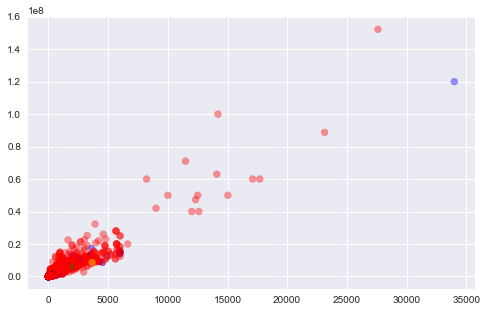

In [325]:
# Let's just make a simple linear regression using size as the feature and cost as the training and fill it in with
# that.

colors = {'residential':'red', 'commercial':'blue', 'government':'green', 'nonprofit':'black',
         'educational': 'yellow', 'agricultural': 'purple', 'utility': 'pink', 'institutional': 'brown',
         'public': 'orange'}


fig = plt.figure(figsize=(8,5))
plt.scatter(x=df['size_kw'], y=df['cost'], color=df['install_type'].apply(lambda x: colors[x]), alpha=0.4)


In [176]:
from sklearn.linear_model import LinearRegression

In [177]:
cost_size = df[['cost', 'size_kw']]
cost_size = cost_size.dropna()

In [178]:
lin_reg = LinearRegression()

In [77]:
cost_size.head()

,cost,size_kw
0,30600.53,10.56
1,40000.00,12.72
2,22665.58,5.40
3,28125.00,7.50
4,19250.00,5.00


In [179]:
X = cost_size['size_kw'].reshape((len(cost_size['size_kw']), 1))

lin_reg.fit(X=X, y=np.array(cost_size['cost']))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [180]:
def fill_cost(row):
    if np.isnan(row['cost']) and not np.isnan(row['size_kw']):
        row['cost'] = lin_reg.predict(row['size_kw'])[0]
    return row


In [181]:
df = df.apply(fill_cost, axis=1)

In [182]:
df['cost'].isnull().sum()

0

In [91]:
df.to_sql("open_pv_clean_backup", con=conn, if_exists="replace")

In [92]:
df.to_sql("open_pv_clean", con=conn, if_exists="replace")

# Moving to some Columns with Few Values

In [169]:
df = pd.read_sql("SELECT * FROM open_pv_clean", con=conn)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020298 entries, 0 to 1020302
Data columns (total 39 columns):
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      224036 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1008901 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null float64
city                           798736 non-null object
utility_clean                  1020298 non-null object
tech_1                         580919 non-null object
model1

In [96]:
# year and date installed are just all the same. ditching year.

df.loc[df.year.notnull(), ['year', 'date_installed']]

,year,date_installed
179671,1/1/2006,01/01/2006
179752,1/1/2000,01/01/2000
179922,1/1/2008,01/01/2008
180066,1/1/2005,01/01/2005
180239,1/1/2002,01/01/2002
180341,1/1/2007,01/01/2007
180377,1/1/2001,01/01/2001
180515,1/1/2006,01/01/2006
180554,1/1/2007,01/01/2007
180700,1/1/2007,01/01/2007


In [183]:
del(df['year'])

In [98]:
# there's just too little information here to do anthing.

df['pbi_length'].value_counts()

5.0     4466
20.0     863
1.0       98
Name: pbi_length, dtype: int64

In [184]:
del(df['pbi_length'])

In [185]:
df.loc[df.utility.notnull(), 'utility_clean'] = df.loc[df.utility.notnull(), 'utility']

In [186]:
del[df['utility']]

In [108]:
# let's just make a new column for this, it's for buildings, just 1 or 0 if they have it.

df.loc[df['bipv_1'].notnull(), ['bipv_1', 'bipv_2', 'bipv_3']]

,bipv_1,bipv_2,bipv_3
97,1.0,1.0,1.0
2868,1.0,1.0,1.0
2869,1.0,1.0,1.0
2870,1.0,1.0,1.0
2871,1.0,1.0,1.0
2872,1.0,1.0,1.0
2873,1.0,1.0,1.0
2874,1.0,1.0,1.0
2875,1.0,1.0,1.0
2876,1.0,1.0,1.0


In [187]:
df['bipv'] = [1 if bipv == 1.0 else 0 for bipv in df['bipv_1']]

In [188]:
del(df['bipv_1'])
del(df['bipv_2'])
del(df['bipv_3'])

In [189]:
# I guess this is whether it's a new construction or somehting? i'll just fill na with 0

df['new_constr'].value_counts()

1.0    27106
Name: new_constr, dtype: int64

In [190]:
df['new_constr'].fillna(0, inplace=True)

In [113]:
# this probably corresponds to if these are "tracking" solar panels, we'll assume the ones that are blank are not,
# so just fill with 0

df['tracking'].value_counts()

1.0    1930
Name: tracking, dtype: int64

In [191]:
df['tracking'].fillna(0, inplace=True)

In [123]:
df.loc[df['manuf1_clean'].notnull(), ['manuf1_clean', 'manuf2_clean', 'manuf3_clean']].head(100)

,manuf1_clean,manuf2_clean,manuf3_clean
0,Chint Solar (Zhejiang),Chint Solar (Zhejiang),Chint Solar (Zhejiang)
14,Phono Solar Technology,Phono Solar Technology,Phono Solar Technology
16,Phono Solar Technology,Phono Solar Technology,Phono Solar Technology
37,Westinghouse Solar,Westinghouse Solar,Westinghouse Solar
38,Westinghouse Solar,Westinghouse Solar,Westinghouse Solar
42,Sharp,Sharp,Sharp
43,Sharp,Sharp,Sharp
54,SunPower,SunPower,SunPower
74,Sharp,Sharp,Sharp
76,Sharp,Sharp,Sharp


In [192]:
del(df['manuf1_clean'])
del(df['manuf3_clean'])

In [193]:
df.rename(columns={'manuf2_clean': "manufacturer"}, inplace=True)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020298 entries, 0 to 1020302
Data columns (total 32 columns):
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      224036 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1008901 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null float64
city                           798736 non-null object
utility_clean                  1020298 non-null object
tech_1                         580919 non-null object
model1

In [127]:
# we may be able to fill in some manufacturer values, i wouldn't be surprised if it's really connected to
# installer,

# also may be connected to size and cost?

df.to_sql("open_pv_clean_backup", con=conn, if_exists='replace')

In [128]:
df.to_sql('open_pv_clean', con=conn, if_exists='replace')

In [194]:
# again just binary, going to fill with 0 for nas

df['appraised'].value_counts()

0    796262
1    224036
Name: appraised, dtype: int64

In [173]:
df['appraised'].fillna(0, inplace=True)

In [133]:
df['lbnl_tts_version_year'].value_counts()

2016.0    797958
Name: lbnl_tts_version_year, dtype: int64

In [135]:
df['lbnl_tts'].value_counts()

1.0    797958
Name: lbnl_tts, dtype: int64

In [195]:
# ok so either you have this thing or you don't the year is always 2016 just going to drop that shit
# and fill the other one with 0

del(df['lbnl_tts_version_year'])
df['lbnl_tts'].fillna(0, inplace=True)

# City

In [196]:
# loading in this mapping of zipcodes to locations, and we can just match the missing values with this.

city_zip = pd.read_csv("./free-zipcode-database-Primary.csv")

In [143]:
city_zip.columns

Index([u'Zipcode', u'ZipCodeType', u'City', u'State', u'LocationType', u'Lat',
       u'Long', u'Location', u'Decommisioned', u'TaxReturnsFiled',
       u'EstimatedPopulation', u'TotalWages'],
      dtype='object')

In [144]:
city_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42522 entries, 0 to 42521
Data columns (total 12 columns):
Zipcode                42522 non-null int64
ZipCodeType            42522 non-null object
City                   42522 non-null object
State                  42522 non-null object
LocationType           42522 non-null object
Lat                    41874 non-null float64
Long                   41874 non-null float64
Location               42521 non-null object
Decommisioned          42522 non-null bool
TaxReturnsFiled        28879 non-null float64
EstimatedPopulation    28879 non-null float64
TotalWages             28844 non-null float64
dtypes: bool(1), float64(5), int64(1), object(5)
memory usage: 3.6+ MB


In [197]:
def fill_city(row):
    if row['city'] is None:
        try:
            row['city'] = city_zip.loc[city_zip['Zipcode'] == int(row['zipcode']), 'City'].values[0]
        except:
            pass
    return row
    
df = df.apply(fill_city, axis=1)

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020298 entries, 0 to 1020302
Data columns (total 31 columns):
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null int64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      702324 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null object
city                           798736 non-null object
utility_clean                  1020298 non-null object
tech_1                         580919 non-null object
model1_clean                   580919 non-null object
county   

In [179]:
df.to_sql('open_pv_clean_backup', con=conn, if_exists='replace')

In [180]:
df.to_sql('open_pv_clean', con=conn, if_exists="replace")

# Starting May 11th

In [15]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
conn = sqlite3.Connection("./capstone.sqlite")

In [5]:
df = pd.read_sql('SELECT * FROM open_pv_clean', con=conn)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020298 entries, 0 to 1020297
Data columns (total 33 columns):
level_0                        1020298 non-null int64
index                          1020298 non-null int64
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1008901 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null float64
city                           1020231 non-null object
utility_clean                  1020298 non-null object
tech

In [7]:
zipcode_df = pd.read_csv("./free-zipcode-database-Primary.csv")

In [ ]:
# I want to do county, but it's going to be tough and there are so few missing values I'm just going to fill with no
# county

In [199]:
df.county.fillna("no_county", inplace=True)

In [10]:
df.tech_1.value_counts()

Poly              350762
Mono              215217
crystalline         7439
Mono + a-Si         5063
CIGS                1097
CdTe                 664
a-Si                 480
a-Si + Micro-c        60
Thin Film             52
CIS                   43
multiple              42
Name: tech_1, dtype: int64

In [12]:
tech_costs = df[['tech_1', 'size_kw', 'cost']].groupby('tech_1').sum()

In [13]:
tech_costs['size/cost'] = tech_costs['size_kw']/tech_costs['cost']  

In [14]:
# we could do a simple t-test to see if there's a difference between these two groups w/r/t cost, or even
# do markov chain monte carlo to see how big that difference is.

,size_kw,cost,size/cost
tech_1,,,
CIGS,4.288079e+04,2.039724e+08,0.000210
CIS,5.676465e+03,2.884693e+07,0.000197
CdTe,2.481990e+04,1.496098e+08,0.000166
Mono,2.324888e+06,1.222352e+10,0.000190
Mono + a-Si,5.230867e+04,3.701955e+08,0.000141
Poly,4.291781e+06,2.134429e+10,0.000201
Thin Film,4.913339e+02,2.610086e+06,0.000188
a-Si,3.163014e+04,1.759568e+08,0.000180
a-Si + Micro-c,1.560455e+03,9.841499e+06,0.000159


In [23]:
mask_1 = df[df['tech_1'] == "Mono"]['cost_per_watt'].notnull()
mask_2 = df[df['tech_1'] == "Poly"]['cost_per_watt'].notnull()

(0, 13)

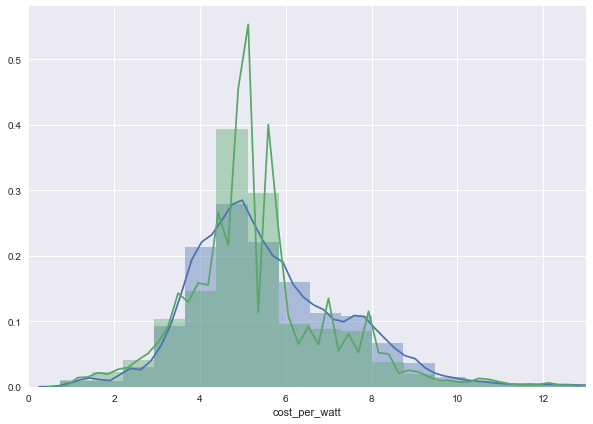

In [33]:
# Hard to see that these distributions are any different...

fig = plt.figure(figsize=(10,7))
sns.distplot(df.loc[df['tech_1'] == "Mono", 'cost_per_watt'].dropna(), bins=40)
sns.distplot(df.loc[df['tech_1'] == "Poly", 'cost_per_watt'].dropna(), bins=40)
plt.xlim((0,13))

In [30]:
from scipy.stats import ttest_ind

ttest_ind(df.loc[df['tech_1'] == "Mono", 'cost_per_watt'].dropna(), df.loc[df['tech_1'] == "Poly", 'cost_per_watt'].dropna(),
         equal_var = False)

Ttest_indResult(statistic=38.152721118064747, pvalue=0.0)

In [31]:
# I don't buy this result...

# maybe some companies only sell certain types of technology?

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020298 entries, 0 to 1020297
Data columns (total 33 columns):
level_0                        1020298 non-null int64
index                          1020298 non-null int64
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1008901 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null float64
city                           1020231 non-null object
utility_clean                  1020298 non-null object
tech

In [43]:
installers_tech = df.groupby(["installer", 'tech_1']).size().reset_index()

In [45]:
installers_tech.sort_values(0, inplace=True, ascending=False)

In [46]:
# interesting that solarcity almost exclusively installs poly.  may be safe to just input poly to all the
# ones where the installer is solarcity

installers_tech

,installer,tech_1,0
9732,SolarCity,Poly,131978
11481,Vivint,Poly,25296
7441,Paradise Energy Solutions,Poly,17868
10561,Sunpower,Mono,14743
7439,Paradise Energy Solutions,Mono,13011
9730,SolarCity,Mono,11608
8202,Rec Solar,Poly,11098
11431,Verengo,Poly,8364
10594,Sunrun,Poly,8236
10507,Sungevity,Poly,7068


In [49]:
# It seems like for a lot of companies they have a main one that they do a lot of.  Just going to input based on
# installer mode.

print df.groupby(["installer", 'tech_1']).size()

installer                                                  tech_1     
 Earth Star Electric                                       Mono              3
                                                           Poly              2
                                                           a-Si              1
01 Electric                                                Poly              2
1 & 1 Electric                                             Poly              1
1 Code Green Solar                                         Poly              1
1 solar source                                             Mono              1
1-Star Energy                                              Poly              3
100% electric                                              Mono             36
                                                           Poly              3
100% solar                                                 Mono              2
                                                           P

In [57]:
installers = df.installer.unique().tolist()
installers.remove(None)

for installer in installers:
    non_nulls = df.loc[df['installer'] == installer, 'tech_1'].notnull().sum()
    if non_nulls == 0:
        df.loc[df['installer'] == installer, 'tech_1'].fillna("Poly", inplace=True)
    else:
        mode_tech = df.loc[df['installer'] == installer, 'tech_1'].value_counts().index[0]
        df.loc[df['installer'] == installer, 'tech_1'].fillna(mode_tech, inplace=True)
        
df['installer'].isnull().sum()

KeyboardInterrupt: 

In [ ]:
# not sure I actually want to do this.



In [58]:
df['3rdparty'].value_counts()

1.0    306993
Name: 3rdparty, dtype: int64

In [200]:
df['3rdparty'].fillna(0, inplace=True)

# Reported annual PV and annual PV:

These columns are really similar.

One way to consolodate these could be to just merge the smaller one into the larger one where there are missing values.

In [60]:
df[['reported_annual_energy_prod', 'annual_PV_prod']]

# these are really just so similar.  Let's do it. # I've also graphed them before, there's really not too many places
# where they differ a lot.

,reported_annual_energy_prod,annual_PV_prod
0,13836.0,14999.831600
1,16419.0,17811.574390
2,7235.0,7833.742822
3,9340.0,10151.709590
4,6729.0,7307.133789
5,4407.0,4787.550469
6,7391.0,NaN
7,9168.0,9941.344116
8,3145.0,3409.052637
9,2474.0,5993.949463


In [201]:
df.annual_PV_prod.fillna(df.reported_annual_energy_prod, inplace=True)

In [63]:
df.annual_PV_prod.isnull().sum()

232835

In [ ]:
# I think that's really as good as we're going to get with this.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020298 entries, 0 to 1020297
Data columns (total 33 columns):
level_0                        1020298 non-null int64
index                          1020298 non-null int64
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1008901 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null float64
city                           1020231 non-null object
utility_clean                  1020298 non-null object
tech

In [ ]:
# That didn't seem to fill in too many values.

In [65]:
df.tracking_type.value_counts()

Fixed          524386
Single-Axis       844
Dual-Axis         541
Mixed             287
Name: tracking_type, dtype: int64

In [ ]:
# I think we can just fill this with "no tracking", though for regression and stuff if we just onehot encode
# it shouldn't actually matter.

In [66]:
# seems like this is the manufacturer, but there's so little data it seems like this will be tough to use.

df['inv_man_clean'].value_counts()

SunPower                              42793
Solectria                              3219
Sharp                                  1873
Schuco USA                             1185
AU Optronics                            156
GE Energy                               131
MAGE Solar                              108
Yes! Solar                               99
CFM                                      80
Siemens                                  72
ET Solar Industry                        56
Powercom                                 34
Open Energy                              29
Canadian Solar                           26
LG Electronics Solar Cell Division       25
Phono Solar Technology                   19
Westinghouse Solar                       10
Honeywell                                 7
GreenVolts                                7
Andalay Solar                             2
Helios USA                                1
Chint Solar (Zhejiang)                    1
Name: inv_man_clean, dtype: int6

In [67]:
# could be helpful to map tilt, I'm wondering if it's geographically related.

df.tilt1.value_counts()

18.000000     52203
20.000000     34293
23.000000     32851
22.000000     31975
30.000000     26932
25.000000     16157
19.000000     15432
15.000000     14359
21.000000     11479
26.000000     11378
24.000000     11295
27.000000     11082
10.000000     11038
17.000000     10411
14.000000      7677
35.000000      7387
16.000000      7017
40.000000      6568
5.000000       5802
34.000000      5702
28.000000      5256
45.000000      4442
32.000000      4237
12.000000      4042
33.000000      3674
37.000000      3082
13.000000      2920
38.000000      2236
36.000000      2233
31.000000      2119
              ...  
15.100000         1
10.400000         1
28.400000         1
19.800000         1
0.460000          1
19.200000         1
24.400000         1
19.300000         1
44.890000         1
18.700000         1
40.400000         1
175.000000        1
23.900000         1
0.270000          1
26.200001         1
260.000000        1
10.600000         1
160.000000        1
43.600000         1


In [72]:
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go

df_small = df.sample(10000)
lat_lon = pd.read_csv("./free-zipcode-database-Primary.csv")
lat_lon = lat_lon[['Zipcode', "Lat", "Long"]]
df_sub = df_small.merge(lat_lon, left_on="zipcode", right_on="Zipcode")

cat = dict(
    type = 'scattergeo',
    locationmode = 'USA-states',
    lat = df_sub['Lat'],
    lon = df_sub['Long'],
    text = df_sub['tilt1'],
    marker = dict(
        size = 10,
        color = df_small['tilt1'],
        line = dict(width=0.5, color='rgb(40,40,40)'),
        sizemode = 'area'
    ),
    name = 'tilt1')

layout = dict(
        title = 'tilt1 <br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=[cat], layout=layout )
py.iplot( fig, validate=False, filename='tilt' )

In [202]:
# looks like tilt has nothing to do with geography really, but probably more to do with something about constraints
# of the location where it's made, like the tilt of the roof it's on.

# not sure how I missed this, want to fill the rest of installer with SolarCity
df.installer.fillna("SolarCity", inplace = True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020298 entries, 0 to 1020297
Data columns (total 33 columns):
level_0                        1020298 non-null int64
index                          1020298 non-null int64
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null float64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1020298 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null float64
city                           1020231 non-null object
utility_clean                  1020298 non-null object
tech

# Rebate

In [203]:
df.rebate = [str(rebate).replace("$", "").replace(",", "") for rebate in df.rebate]

In [209]:
df.rebate = [rebate if rebate != 'nan' else np.nan for rebate in df.rebate]

In [210]:
# I'm going to fill rebate with 0s where it's null, probably means there was no rebate.

df.rebate.fillna(0, inplace=True)

In [211]:
df.rebate = pd.to_numeric(df.rebate)

In [214]:
conn.text_factory = str

df.to_sql("open_pv_clean_backup", con=conn, if_exists='replace')


In [215]:
df.to_sql("open_pv_clean", con=conn, if_exists='replace')


# Date Installed.

This is currently and object, let's make it a datetime.

In [115]:
df.date_installed = pd.to_datetime(df.date_installed)

# More Utility Cleaning

Considering that we have so many installers, we may want to go ahead and limit it to say the top 10, or some smaller number that encapsulates a lot of the data, and then lump the rest in an "other utility" category.



In [ ]:
# There are a few that really dominate our data set

In [216]:
# I messed up Utility Clean, I changed everything in the state instead of filling na...

df.groupby(['state', 'utility_clean']).size()

state  utility_clean                                    
AK     no utility listed                                       22
AL     no utility listed                                       32
AR     Arkansas Valley Electric Cooperative Corporation        10
       C&amp;L Electric Cooperative Corporation                 1
       Carroll Electric Coop Corp                               1
       Carroll Electric Coop Corp - (AR)                        1
       Carroll Electric Cooperative Corporation                10
       Entergy Arkansas Inc                                   153
       Entergy Arkansas, Inc.                                   6
       First Electric Cooperative Corporation                   3
       North Arkansas Electric Cooperative, Incorporated        4
       Oklahoma Gas & Electric Co                               3
       Oklahoma Gas and Electric Company (OG&amp;E)             3
       Ozarks Electric Cooperative Corporation                  6
       Petit Jean E

In [217]:
df.utility_clean.value_counts()

Pacific Gas & Electric Company               352633
Southern California Edison                   164476
San Diego Gas & Electric Company              70941
Arizona Public Service                        57985
National Grid                                 52156
JCP&L                                         25237
PSEG Long Island                              24991
Connecticut Light and Power                   21307
Los Angeles Department of Water & Power       19757
NSTAR (DBA EverSource)                        16698
PSE&G BPU                                     15883
Salt River Project                            15275
Nevada Power                                  14102
no utility listed                             12930
Sacramento Municipal Utility District         11698
Tucson Electric Power                         10921
Baltimore Gas & Electric Co                   10349
Austin Energy                                  9196
AC Electric                                    8948
Public Servi

In [ ]:
# This isn't actually SO long, but still it seems like we wouldn't lose too much by going
# from 400 to like 30 or 40

In [219]:
len(df.utility_clean.value_counts().tolist())

441

In [224]:
print sum(df.utility_clean.value_counts()[0:50]), sum(df.utility_clean.value_counts()[50:])

1000272 20026


In [227]:
# even just limiting to the top 30 gets 95% of our data

# for now I'm just going to use the top 50, we can always use even fewer.

# Before doing that, I'm going to look over an ordered list of the utilities and see if there are some
# mislabeled ones we can get rid of.

sorted_utils = sorted(df.utility_clean.value_counts().index.tolist())

# one's to change:

- APE-T: AEP-TCC
- Alliant
- Ameren
- Ashland
- BHE
- Burlington Elec
- Carroll Electric Cooperative Corporation + Electric Cooperative Corporation
- City of St Charles
- ComEd = Commonwealth Edison Co
- Connecticut Light
- Coos-Curry Electric Coop
- Delmarva
- Duquesne
- El Paso Electric
- Entergy
- Idaho Power Co
- Carroll Energy = Jo Carrol Energy
- Kit Carson Electric Coop
- Littleton
- Massachusetts Electric
- McDonough Power
- Menard Electric
- MidAmerican Energy
- Minnesota Power
- NSTAR
- Nicor Gas
- Norris Elec = Norris Electric
- North Shore Gas
- Northern States Power Co
- Oklahoma Gas = Oklahoma Gas and Eletric Company
- Oncor not Concord
- "Orange ": Orange and Rockland
- Oregon Trail = Oregon Trail Coop
- PECO
- PPL Electric Utilities
- Portland General Electric
- Sierra Pacific
- Southern California Edison
- Southwestern Electric
- Springfield 
- Superior Water: Superior Water and Light
- The Potomac Edison Co
- Tri-County Electric
- Umatilla Electric Coop
- Wasco Electric Coop
- West Penn Power Co


In [229]:
sorted_utils

['AC Electric',
 'AEP-TCC',
 'AEP-TNC',
 'Adams Electric Cooperative',
 'Ajo Improvement Company',
 'Alexandria Light & Power',
 'Allegheny (West Penn)',
 'Alliant',
 'Alliant Energy',
 'Ameren',
 'Ameren CILCO',
 'Ameren CIPS',
 'Ameren IP',
 'Ameren Illinois Company',
 'Ameren/CILCO',
 'Ameren/CIPS',
 'Ameren/IL',
 'Ameren/IP',
 'AmerenCILCO',
 'AmerenCIPS',
 'AmerenIP',
 'AmeriGas',
 'Arizona Public Service',
 'Arkansas Valley Electric Cooperative Corporation',
 'Arrowhead Coop',
 'Ashburnham Municipal Light Plant',
 'Ashland Elec. Dept.',
 'Ashland, City Of',
 'Atlantic City Electric Co',
 'Austin Energy',
 'Austin Public Utilities',
 'BHE',
 'BHE     ',
 'Baltimore Gas & Electric Co',
 'Bandon, City Of',
 'Barron Electric Coop',
 'Bear Valley Electric Service',
 'Belmont Light',
 'Beltrami Electric',
 'Benco Electric Cooperative',
 'Blachly-Lane County Coop. Electric Assn',
 'BlueStar Energy Solutions',
 'Boro of Milltown Elec',
 'Boylston Electric Light Department',
 'Brainerd Pu

In [232]:
# one's to change:

utility_map = {
    "APE-T": "AEP-TCC",
    "Alliant": "Alliant",
    "Ameren": "Ameren",
    "Ashland": "Ashland",
    "BHE": "BHE",
    "Burlington Elec": "Burlington Elec",
    "Electric Cooperative Corporation": "Carroll Electric Cooperative Corporation",  
    "City of St Charles": "City of St Charles",
    "ComEd": "Commonwealth Edison Co",
    "Connecticut Light": "Connecticut Light",
    "Coos-Curry Electric Coop": "Coos-Curry Electric Coop",
    "Delmarva": "Delmarva",
    "Duquesne": "Duquesne",
    "El Paso Electric": "El Paso Electric",
    "Entergy":  "Entergy",
    "Idaho Power Co": "Idaho Power Co",
    "Carroll Energy": "Jo Carrol Energy",
    "Kit Carson Electric Coop": "Kit Carson Electric Coop",
    "Littleton": "Littleton",
    "Massachusetts Electric": "Massachusetts Electric",
    "McDonough Power": "McDonough Power",
    "Menard Electric": "Menard Electric",
    "MidAmerican Energy": "MidAmerican Energy",
    "Minnesota Power": "Minnesota Power",
    "NSTAR": "NSTAR",
    "Nicor Gas": "Nicor Gas",
    "Norris Elec": "Norris Electric",
    "North Shore Gas": "North Shore Gas",
    "Northern States Power Co": "Northern States Power Co",
    "Oklahoma Gas": "Oklahoma Gas and Eletric Company",
    "Oncor": "Oncor",
    "Orange ": "Orange and Rockland",
    "Oregon Trail": "Oregon Trail Coop",
    "PECO": "PECO",
    "PPL Electric Utilities": "PPL Electric Utilities",
    "Portland General Electric": "Portland General Electric",
    "Sierra Pacific": "Sierra Pacific",
    "Southern California Edison": "Southern California Edison",
    "Southwestern Electric" : "Southwestern Electric",
    "Springfield": "Springfield",
    "Superior Water": "Superior Water and Light",
    "The Potomac Edison Co": "The Potomac Edison Co",
    "Tri-County Electric": "Tri-County Electric",
    "Umatilla Electric Coop": "Umatilla Electric Coop",
    "Wasco Electric Coop": "Wasco Electric Coop",
    "West Penn Power Co": "West Penn Power Co",
}


In [235]:
for key, value in utility_map.items():
    df.utility_clean = [value if key in utility else utility for utility in df.utility_clean]

In [237]:
# we got rid of a bunch :)

len(df.utility_clean.value_counts())

370

In [238]:
# now we can do some grouping.

df.utility_clean.value_counts()

Pacific Gas & Electric Company               352633
Southern California Edison                   167012
San Diego Gas & Electric Company              70941
Arizona Public Service                        57985
National Grid                                 52156
JCP&L                                         25237
PSEG Long Island                              24991
Connecticut Light                             21556
Los Angeles Department of Water & Power       19757
NSTAR                                         18373
PSE&G BPU                                     15883
Salt River Project                            15275
Nevada Power                                  14102
no utility listed                             12930
Sacramento Municipal Utility District         11698
Tucson Electric Power                         10921
Baltimore Gas & Electric Co                   10349
Austin Energy                                  9196
AC Electric                                    8948
PPL Electric

In [243]:
# Making a list of the top 50 utilities and the "no utility listed" category
# will loop through these to do matching, and name ones that aren't in this "other"

top_50_utils = df.utility_clean.value_counts().index.tolist()[0:50]
top_50_utils.append("no utility listed")

In [244]:
df.utility_clean = [utility if utility in top_50_utils else "other" for utility in df.utility_clean]

In [246]:
# Reduced Utilities to top 50 and other.

len(df.utility_clean.value_counts())

51

In [248]:
df.to_sql("open_pv_clean_backup", con=conn, if_exists='replace')

In [249]:
df.to_sql("open_pv_clean", con=conn, if_exists='replace')

# Incentive Programs

I'd like to get down the number of incentive program names, similar to utility names.

In [251]:
# it's not actually too bad, but maybe there's some mislabeling?

len(df.incentive_prog_names.value_counts())

66

In [252]:
# Doesn't look like there's much to be done here, just going to leave it be.

incentive_progs = sorted(df.incentive_prog_names.unique())
incentive_progs

['Ajo Improvement Company',
 'Ameren',
 'Arizona Public Service',
 'Arkansas State Energy Office',
 'Austin Energy',
 'Bear Valley Electric (California Center for Sustainable Energy)',
 'CPS Energy',
 'California Energy Commission (Emerging Renewables Program)',
 'California Energy Commission (New Solar Homes Partnership)',
 'California Public Utilities Commission (California Solar Initiative)',
 'California Public Utilities Commission (Non-CSI Net Metered Systems)',
 'California Public Utilities Commission (Self-Generation Incentive Program)',
 'City of Palo Alto Utilities',
 'Connecticut Clean Energy Finance and Investment Authority',
 'Delaware Department of Natural Resources and Environmental Control',
 'Duncan Valley Electric Cooperative',
 'Efficiency Maine',
 'El Paso Electric',
 'Entergy',
 'Florida Energy & Climate Commission',
 'Gainesville Regional Utilities',
 'Graham County Electric Cooperative',
 'Illinois Department of Commerce & Economic Opportunity',
 'Imperial Irrigat

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020298 entries, 0 to 1020302
Data columns (total 31 columns):
state                          1020298 non-null object
date_installed                 1020298 non-null object
incentive_prog_names           1020298 non-null object
type                           1020298 non-null object
size_kw                        1020298 non-null float64
appraised                      1020298 non-null int64
zipcode                        1020298 non-null float64
install_type                   1020298 non-null object
installer                      1020298 non-null object
cost_per_watt                  762737 non-null float64
cost                           1020298 non-null float64
lbnl_tts                       1020298 non-null object
city                           798736 non-null object
utility_clean                  1020298 non-null object
tech_1                         580919 non-null object
model1_clean                   580919 non-null object
county  

## Tracking + Tilt

What is the tilt value for installations that have tracking?

In [ ]:
mask = df[df['tracking'] = 1]

In [259]:
print df.loc[mask, 'tilt1'].isnull().sum()
print df.loc[mask, 'tilt1'].notnull().sum()

# if anything, having tracking makes it MORE likely that you'll have tilt listed.

107807
116229


# Starting to Drop Columns and NAs to build Final Dataset.

At this point it seems like I may have exhausted my ability to clean up this dataset much more.

columns to include:

- state                          
- date_installed                 
- incentive_prog_names           
- type                          
- size_kw                        
- appraised                      
- zipcode                        
- install_type                   
- installer                      
- cost_per_watt 
- lbnl_tts                      
- utility_clean                 
- model1_clean                   
- annual_PV_prod                 
- annual_insolation              
- tech_1                         
- rebate                         
- new_constr                     
- tracking                       
- 3rdparty                       
- bipv                           

In [91]:
df_final = df[['state', 'date_installed', 'incentive_prog_names', 'type', 'size_kw', 'appraised', 'install_type',
              'installer', 'cost_per_watt', 'lbnl_tts', 'utility_clean', 'model1_clean', 'annual_PV_prod', 
              'annual_insolation', 'tech_1', 'rebate', 'new_constr', 'tracking', '3rdparty', 'bipv']]

In [92]:
# dropping any row where we don't have cost per watt, given that's ultimately what I'm interesting in predicting.

# It might actually be more interesting to look at predicting annual PV produced, but we can look into that later.

df_final = df_final[df_final.cost_per_watt.notnull()]

In [93]:
# there are some tough calls to make here, to drop the columns with null values, or to drop a bunch of rows.
# I could try training models both ways and see what happens.

df_final.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762737 entries, 0 to 1020297
Data columns (total 20 columns):
state                   762737 non-null object
date_installed          762737 non-null object
incentive_prog_names    762737 non-null object
type                    762737 non-null object
size_kw                 762737 non-null float64
appraised               762737 non-null float64
install_type            762737 non-null object
installer               762737 non-null object
cost_per_watt           762737 non-null float64
lbnl_tts                762737 non-null float64
utility_clean           762737 non-null object
model1_clean            422387 non-null object
annual_PV_prod          556526 non-null float64
annual_insolation       550320 non-null float64
tech_1                  422387 non-null object
rebate                  762737 non-null float64
new_constr              762737 non-null float64
tracking                762737 non-null float64
3rdparty                762737 no

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
rand_for = RandomForestClassifier(max_features = 'auto', min_samples_split = 20)

In [96]:
from sklearn.model_selection import train_test_split

In [98]:
df_final.date_installed = pd.to_datetime(df_final.date_installed)


In [ ]:
df_final.date_installed = pd.to_numeric(df_final.date_installed)

In [108]:
df_final.rename(columns = {'3rdparty': "third_party"}, inplace=True)

In [113]:
import patsy

formula = "cost_per_watt ~ state + date_installed + incentive_prog_names + type + size_kw + appraised + install_type + installer + lbnl_tts + utility_clean + rebate + new_constr + tracking + third_party + bipv"

In [114]:
y, X = patsy.dmatrices(formula, df_final, return_type = 'dataframe')

KeyboardInterrupt: 

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

ValueError: At least one array required as input